<div class="alert alert-block alert-info">
    <h1>New York City Taxi and Limousine Commission data for Green Taxis</h1>
    
    
By - Chahak Sethi
    
email id - csethi2@dons.usfca.edu

In [44]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'retina' 

### 1.1 Reading and exploring data

In [45]:
df = pd.read_parquet('green_tripdata_2016-12.parquet', engine='pyarrow')
df.shape

(1224158, 20)

In [3]:
df.sample(4).T

,1162056,670589,646033,949819
VendorID,2,2,2,2
lpep_pickup_datetime,2016-12-30 18:32:40,2016-12-17 00:29:06,2016-12-16 17:36:58,2016-12-23 20:00:03
lpep_dropoff_datetime,2016-12-30 18:42:21,2016-12-17 00:34:03,2016-12-16 18:04:15,2016-12-23 20:04:04
store_and_fwd_flag,N,N,N,N
RatecodeID,1,1,1,1
PULocationID,7,256,53,166
DOLocationID,179,80,83,42
passenger_count,6,1,1,1
trip_distance,1.0,1.0,5.21,0.75
fare_amount,8.0,5.5,22.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224158 entries, 0 to 1224157
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1224158 non-null  int64         
 1   lpep_pickup_datetime   1224158 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  1224158 non-null  datetime64[ns]
 3   store_and_fwd_flag     1224158 non-null  object        
 4   RatecodeID             1224158 non-null  int64         
 5   PULocationID           1224158 non-null  int64         
 6   DOLocationID           1224158 non-null  int64         
 7   passenger_count        1224158 non-null  int64         
 8   trip_distance          1224158 non-null  float64       
 9   fare_amount            1224158 non-null  float64       
 10  extra                  1224158 non-null  float64       
 11  mta_tax                1224158 non-null  float64       
 12  tip_amount             12241

In [46]:
#dropping as all zeroes
df = df.drop(columns=['ehail_fee','congestion_surcharge'])

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.drop(columns=["VendorID", "RatecodeID","PULocationID","DOLocationID"]).describe([.01,.1,.25,.5,.75,.95,.99,.995,.999])

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
count,1224158.000,1224158.000,1224158.000,1224158.000,1224158.000,1224158.000,1224158.000,1224158.000,1224158.000,1224158.000,1224158.000
mean,1.362,2.618,11.594,0.363,0.487,1.129,0.095,0.293,13.999,1.535,1.020
std,1.037,2.806,9.793,0.390,0.085,2.216,0.881,0.051,11.129,0.524,0.139
min,0.000,0.000,-499.000,-4.500,-0.500,-10.560,-8.540,-0.300,-499.000,1.000,1.000
1%,1.000,0.000,2.500,0.000,0.000,0.000,0.000,0.000,3.800,1.000,1.000
10%,1.000,0.610,4.500,0.000,0.500,0.000,0.000,0.300,6.300,1.000,1.000
25%,1.000,0.980,6.000,0.000,0.500,0.000,0.000,0.300,7.800,1.000,1.000
50%,1.000,1.700,9.000,0.500,0.500,0.000,0.000,0.300,10.800,2.000,1.000
75%,1.000,3.200,14.000,0.500,0.500,1.860,0.000,0.300,16.560,2.000,1.000
95%,5.000,7.840,28.000,1.000,0.500,4.760,0.000,0.300,33.300,2.000,1.000


In [38]:
df[df['trip_distance'] == 0].shape[0]*100/df.shape[0]

1.240281074828576

In [40]:
df[df['fare_amount'] <= 0].shape[0]*100/df.shape[0]

0.49348205051962246

<div class="alert alert-block alert-success">  

The data quality is not very good. There are a lot of outliers.
    
    
- 1.2% observations have trip distance as 0
- 0.5% observations have negative or 0 fare amount. They may be corresponding to transactions being reversed, there is no one to one mapping to payment type being disputed
- Fare amount, tip amount, and tolls amount have unreliably high outliers on the positive side.
- Number of passengers are a shigh as 9 which is beyond the capacity of a typical cab which has maximum capacity of 5 passengers

In [47]:
## Remove trip distance = 0 
print('Removing trips whose trip distance = 0')
df = df[df['trip_distance'] > 0]
print('Remaining number of records:', df.shape[0])

Removing trips whose trip distance = 0
Remaining number of records: 1208975


<div class="alert alert-block alert-success">
        Trips with distance = 0 are not very helpful in our analysis as they do not make a lot of sense. At certain places drivers report the fields manually, this could have been an error in reporting. Thus, removing these from our analysis.

### 1.2 Creating New Features

In [48]:
#creating new features
df['day_of_week'] = pd.Categorical(pd.to_datetime(df['lpep_pickup_datetime']).dt.dayofweek)
df['weekend'] = ((df['day_of_week']==5)|(df['day_of_week']==6)).astype(int)
df['pickup_hour'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.hour
df['dropoff_hour'] = pd.to_datetime(df['lpep_dropoff_datetime']).dt.hour
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
#duration in minutes
df['duration'] = pd.to_timedelta(df['duration'])/pd.Timedelta('60s')
df['avg_speed'] = df['trip_distance']*60/df['duration']

### 1.3 Visualizations

#### Trip Distance

Text(0, 0.5, 'Count')

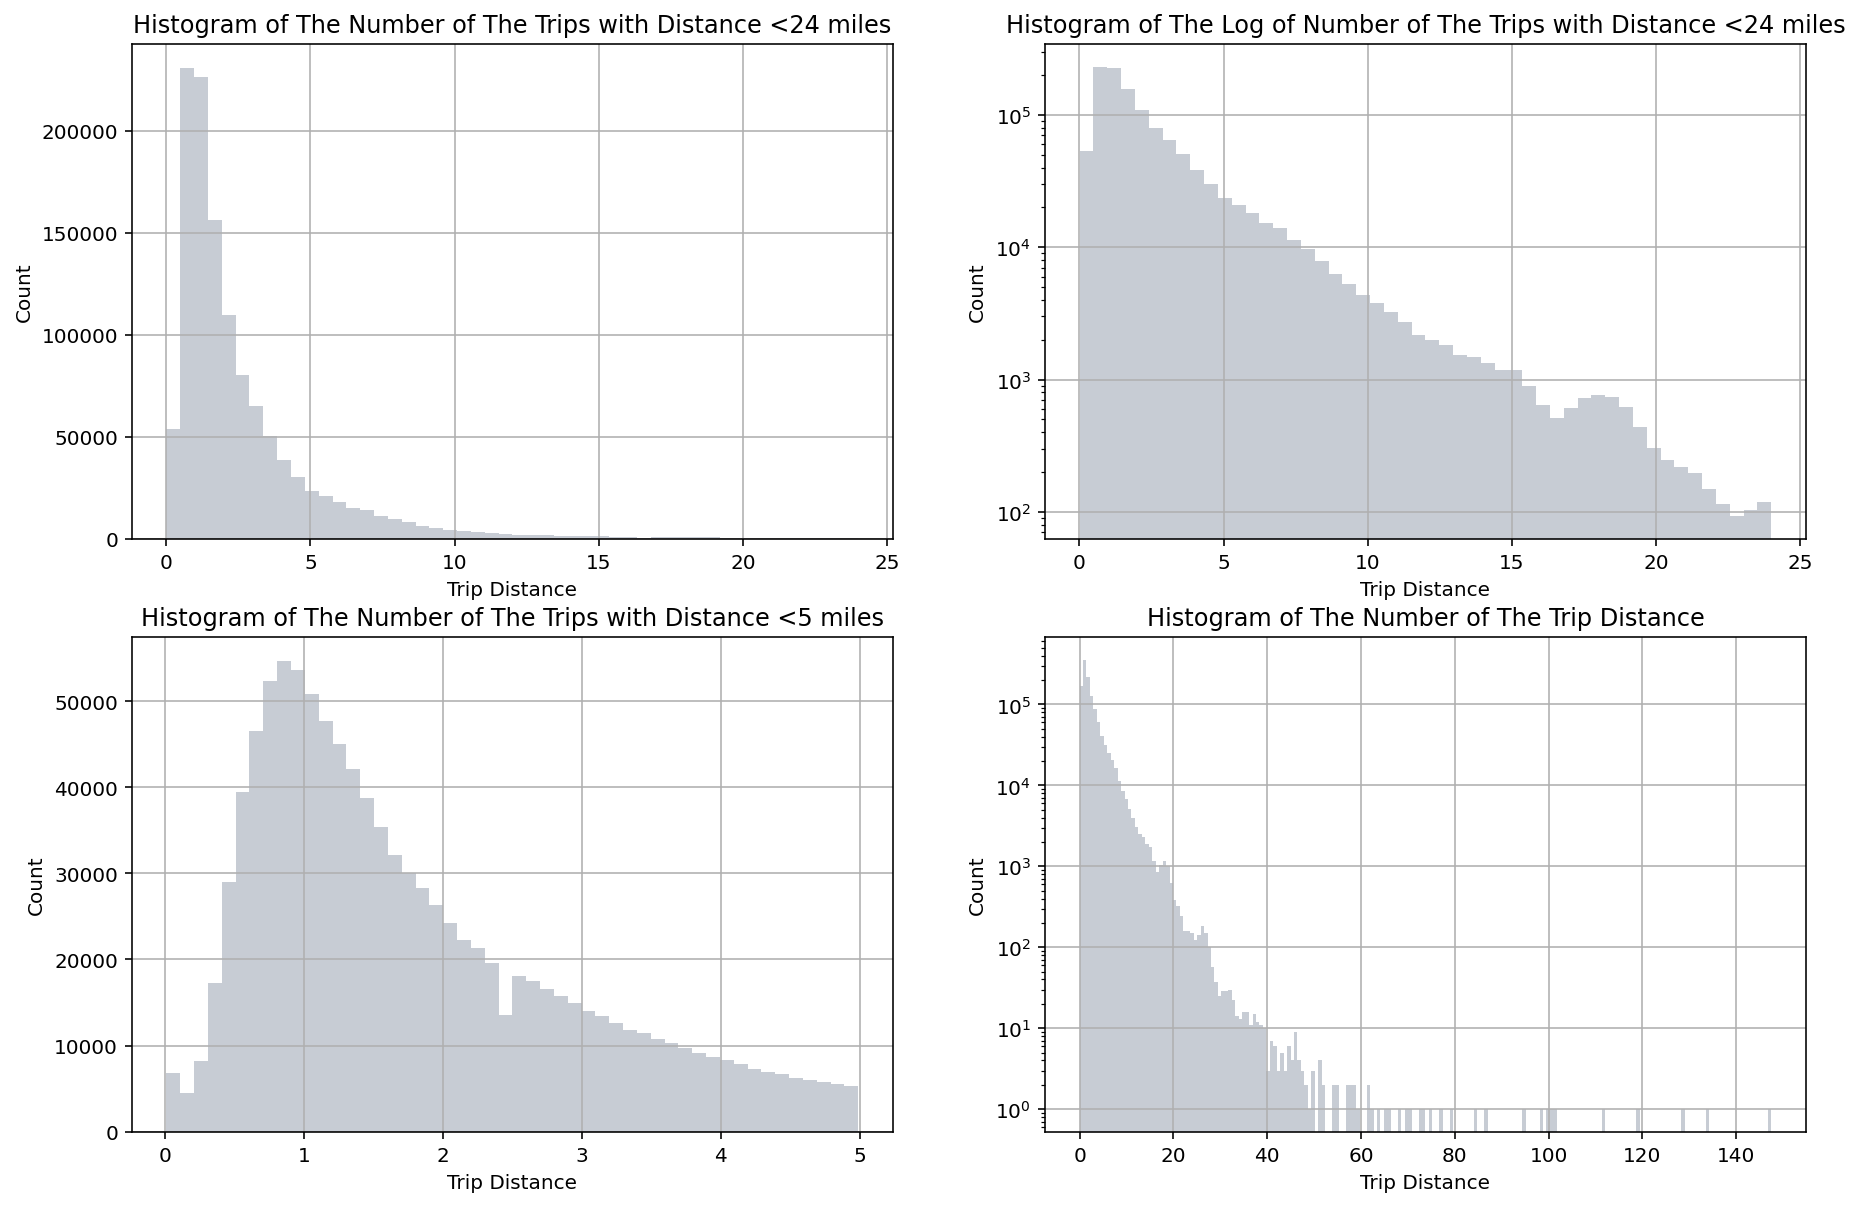

In [9]:
## To make the figures clear, let's only see the ones with trip distance < 24 miles (99.9 percentile).
fig, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15,10))

df['trip_distance'][df['trip_distance'] < 24].hist(ax=ax1, bins=50,color='#c7ccd4')
ax1.set_title('Histogram of The Number of The Trips with Distance <24 miles')
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Count')

df['trip_distance'][df['trip_distance'] <24].hist(ax=ax2, bins=50,color='#c7ccd4')
ax2.set_yscale('log')
ax2.set_title('Histogram of The Log of Number of The Trips with Distance <24 miles')
ax2.set_xlabel('Trip Distance')
ax2.set_ylabel('Count')


df['trip_distance'][df['trip_distance'] < 5].hist(ax=ax3, bins=50,color='#c7ccd4')
ax3.set_title('Histogram of The Number of The Trips with Distance <5 miles')
ax3.set_xlabel('Trip Distance')
ax3.set_ylabel('Count')

df['trip_distance'].hist(ax=ax4, bins=200,color='#c7ccd4')
ax4.set_yscale('log')
ax4.set_title('Histogram of The Number of The Trip Distance')
ax4.set_xlabel('Trip Distance')
ax4.set_ylabel('Count')

<div class="alert alert-block alert-success">
    From the above figures, we can see that:

 - When trip distance > 1 mile, as the trip distance increases, its count decreases;

 - when trip distance < 1 mile, as the trip distance increases, its count increases.

In reality, it makes sense that most taxi trips are short trips（aruound 1-2 miles). Becuase for long trips, it would be expensive to take a taxi, and people probably would choose public transportations like metro or bus to save their money. While for short trips, people probably prefer to choose taxi to save their time.

#### Number of passengers

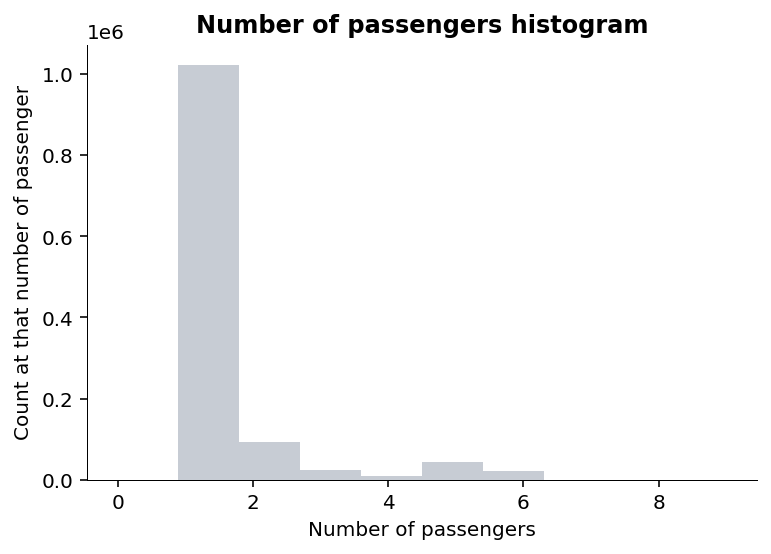

In [10]:
fig, ax = plt.subplots(figsize=(6,4))  

# save the results of hist
n, bins, patches = ax.hist(df['passenger_count'], color='#c7ccd4', bins=10)  

#set labels and title
ax.set_xlabel("Number of passengers")
ax.set_ylabel("Count at that number of passenger")
ax.set_title("Number of passengers histogram",weight='bold')

# make the frame look good
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

plt.show()

<div class="alert alert-block alert-success">
    Most of the trips have only a single passengers. 

#### Payment Type

In [11]:
df.groupby('payment_type')['fare_amount'].mean()

payment_type
1   12.780
2   10.505
3    4.722
4    6.693
5   11.276
Name: fare_amount, dtype: float64

In [12]:
## Payment type by Total Amount
pt1 = df[df['payment_type']==1]['total_amount'].values
pt2 = df[df['payment_type']==2]['total_amount'].values
pt3 = df[df['payment_type']==3]['total_amount'].values
pt4 = df[df['payment_type']==4]['total_amount'].values
pt5 = df[df['payment_type']==5]['total_amount'].values

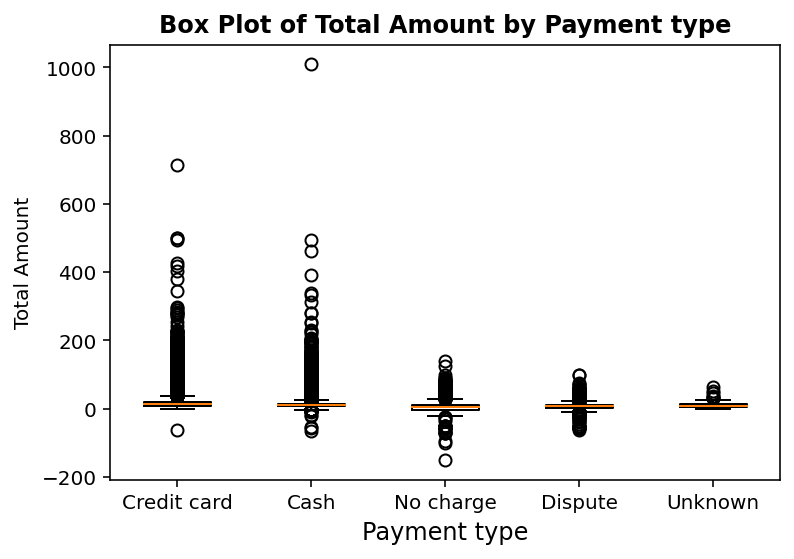

In [13]:
pt_type_fare=[pt1,pt2,pt3,pt4,pt5]

fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot(pt_type_fare)

ax.set_xlabel("Payment type", size=12)
ax.set_ylabel("Total Amount")
ax.set_title("Box Plot of Total Amount by Payment type", weight="bold")
ax.set_xticklabels(["Credit card", "Cash", "No charge", "Dispute", "Unknown"])

plt.show()

<div class="alert alert-block alert-success">
    Most of the payment types are credit card and cash and they have large amount of transactions. 

No charge and dispute have most of the reversed transactions (-ve total amount) which is obvious from the trasaction type.

#### RateCode ID

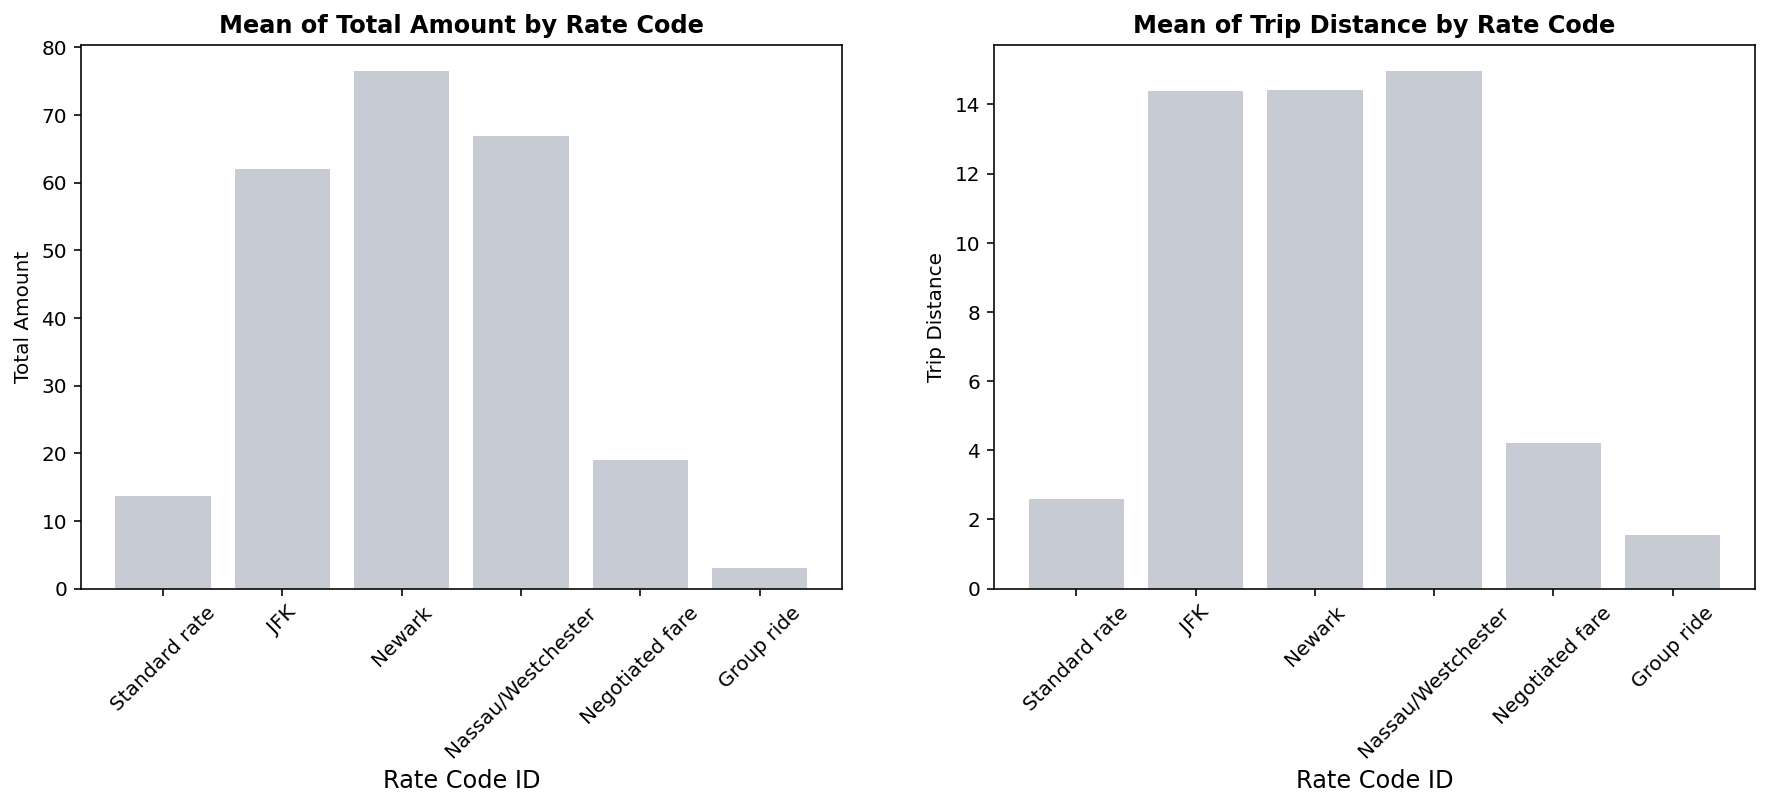

In [14]:
fig,((ax1, ax2)) = plt.subplots(1,2, figsize = (15,5))

pt_type_fare=["Standard rate", "JFK","Newark","Nassau/Westchester", "Negotiated fare", "Group ride"]
mean_amnt_rt = df['total_amount'].groupby(df['RatecodeID']).mean()
mean_tpdst_rt = df['trip_distance'].groupby(df['RatecodeID']).mean()

ax1.bar(pt_type_fare, height = mean_amnt_rt,color='#c7ccd4')
ax1.set_xlabel("Rate Code ID", size=12)
ax1.set_ylabel("Total Amount")
ax1.set_title("Mean of Total Amount by Rate Code", weight="bold")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax2.bar(pt_type_fare, height = mean_tpdst_rt, color='#c7ccd4')
ax2.set_xlabel("Rate Code ID", size=12)
ax2.set_ylabel("Trip Distance")
ax2.set_title("Mean of Trip Distance by Rate Code", weight="bold")
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.show()

<div class="alert alert-block alert-success">

The highest mean total amount of trips have rate code Newark and Nassau/Westchester.

The mean trip distance is also the highest for JFK, Neward and Nassau/Westchester.

### 1.4 Statistics grouped by hour of the day

Text(0.5, 1.0, 'Mean Trip Distance Grouped by Hour of Day')

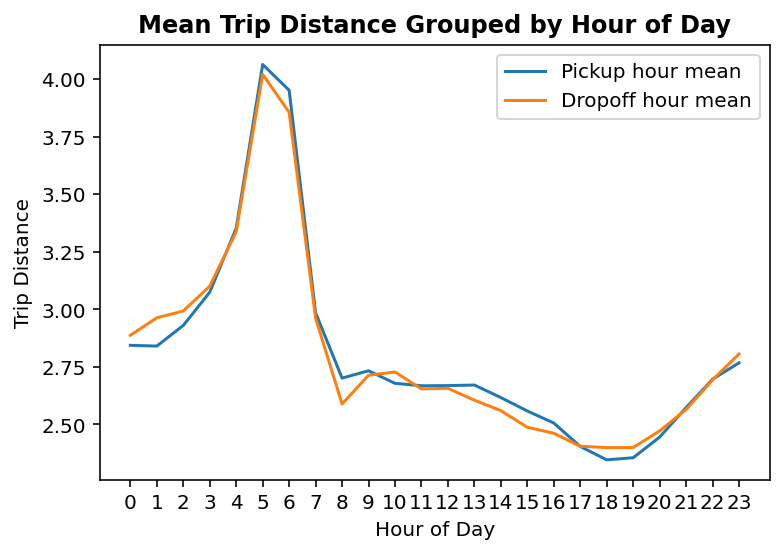

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
## group by hour, get the mean 
mean_dist_pickup = df['trip_distance'].groupby(df['pickup_hour']).mean()
mean_dist_dropoff = df['trip_distance'].groupby(df['dropoff_hour']).mean()

## visualize the dataframe
ax.plot(mean_dist_pickup, label='Pickup hour mean')
ax.plot(mean_dist_dropoff, label='Dropoff hour mean')
ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Trip Distance")
ax.legend()
ax.set_title("Mean Trip Distance Grouped by Hour of Day", weight='bold')

<div class="alert alert-block alert-success">
    
The trip distance grouped by hour of day calculated from pickup and dropoff are similar;

- Trip distance appears to be the longest during 4am-7am
- Trip distance appears to be the shortest during 7am-9pm
- Trip distance appears to be medium during 9pm-4am

Text(0.5, 1.0, 'Mean Trip Duration Grouped by Hour of Day')

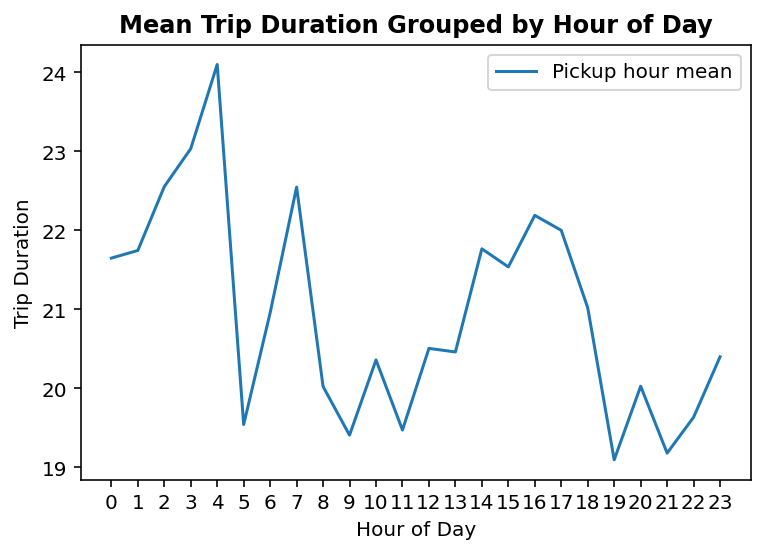

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
## group by hour, get the mean 
mean_dist_pickup = df['duration'].groupby(df['pickup_hour']).mean()
mean_dist_dropoff = df['duration'].groupby(df['dropoff_hour']).mean()

## visualize the dataframe
ax.plot(mean_dist_pickup, label='Pickup hour mean')
# ax.plot(mean_dist_dropoff, label='Dropoff hour mean')
ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Trip Duration")
ax.legend()
ax.set_title("Mean Trip Duration Grouped by Hour of Day", weight='bold')

<div class="alert alert-block alert-success">
    
There is no clean trend in the mean trip duration grouped by hour of the day but roughly the trend looks like the following:

- It seems to be peaking around 2-7 am 
- Avg mean distance was observed between 2 pm to 7pm
- Other times have low mena trip duration

### 1.5 Model to identify factors affecting driver tips

According to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml, the initial charge is $2.50, so remove trips whose total amount < 2.5.

In [55]:
print('Removing trips whose total amount < $2.5')
df = df[df['total_amount'] > 2.5]
print('Remianing number of records:', df.shape[0])

Removing trips whose total amount < $2.5
Remianing number of records: 1204232


Create a subset called df_tip with payment type = 1 (credit card) - As we have tips for only Credit card payments

In [56]:
print('Keep trips paid by credit card ...')
df_tip = df[df['payment_type'] == 1]
print('Remianing number of records: ', df_tip.shape[0])

Keep trips paid by credit card ...
Remianing number of records:  574879


Removing records with duration greater than 8 hours (480 mins) - because they are not very obvious
maybe caused by some issues in recording of the data or unrepresentative outliers

In [57]:
df_tip = df_tip[df_tip['duration']<=480]
print('Remianing number of records less than 8 hours duration: ', df_tip.shape[0])

Remianing number of records less than 8 hours duration:  571883


In [58]:
print('Avg speed description (miles/hour):')
print(df_tip['avg_speed'].describe()[3:])

Avg speed description (miles/hour):
min    0.003
25%    9.223
50%   11.566
75%   14.771
max      inf
Name: avg_speed, dtype: float64


Removing records with avg speed greater than 80 miles per hour - because it's very unrealistic to drive above that speed

In [59]:
df_tip = df_tip[df_tip['avg_speed']<=80]
print('Remianing number of records less than 80 miles per hour avg speed: ', df_tip.shape[0])

Remianing number of records less than 80 miles per hour avg speed:  570708


In [60]:
pd.set_option('mode.chained_assignment',None)
df_tip['other_amount'] = df_tip['extra'] + df_tip['mta_tax'] + \
                         df_tip['tolls_amount'] + df_tip['improvement_surcharge']

There are only 65 accounts with 0 fare amount. This will give unreliably high tip rate which is not reflective of the real tip rate.

If the number of such accounts would have been higher, I would create a proxy fare amount for them by calculating the average fare per mile for all the trips and multiplying the avg fare to the distances travelled for such cases.

In [61]:
# check the number of trips with 0 fare amount
print('Number of trips with 0 fare amount: ', df_tip[df_tip['fare_amount']==0].shape[0])
df_tip = df_tip[df_tip['fare_amount']>0]
print('Remianing number of records less than 80 miles per hour avg speed: ', df_tip.shape[0])

Number of trips with 0 fare amount:  65
Remianing number of records less than 80 miles per hour avg speed:  570643


Creating a variable "tip rate", that is, the percentage of tip amount over the total amount. Predicting raw tip amounts may not be very helpful but predicting the tip percentage of the total fare amount maybe helpful in understanding the factors affecting the tip.

In [62]:
df_tip['tip_rate'] = 100*df_tip['tip_amount']/df_tip['total_amount']

# check the number of trips without tip
print('Number of trips with zero tips: ', df_tip[df_tip['tip_rate']==0].shape[0])
print('The percentage of trips with zero tips: ',
     round(100*df_tip[df_tip['tip_rate']==0].shape[0]/df_tip.shape[0],2), '%')

Number of trips with zero tips:  83244
The percentage of trips with zero tips:  14.59 %


In [75]:
X = df_tip[['trip_distance', 'duration','fare_amount', 'other_amount', 'pickup_hour','passenger_count', \
         'avg_speed','RatecodeID','trip_type','day_of_week','weekend']]

# target y
y = df_tip['tip_rate']

X_cat_1 = pd.get_dummies(X['RatecodeID'],prefix='RatecodeID',drop_first=False)
X_cat_2 = pd.get_dummies(X['trip_type'],prefix='trip_type',drop_first=False)
X_cat_3 = pd.get_dummies(X['day_of_week'],prefix='day_of_week',drop_first=False)
X = X.join(X_cat_2).join(X_cat_1).join(X_cat_3)
X = X.drop(columns = ['RatecodeID','trip_type','day_of_week'])

In [76]:
## Split data into a training dataset and a test dataset (7:3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

One-Hot Encoding the categorical variables. Will be helpful in interpreting features that are predictive in nature.

In [77]:
X_train.shape

(399450, 22)

##### Checking correlation amongst the features

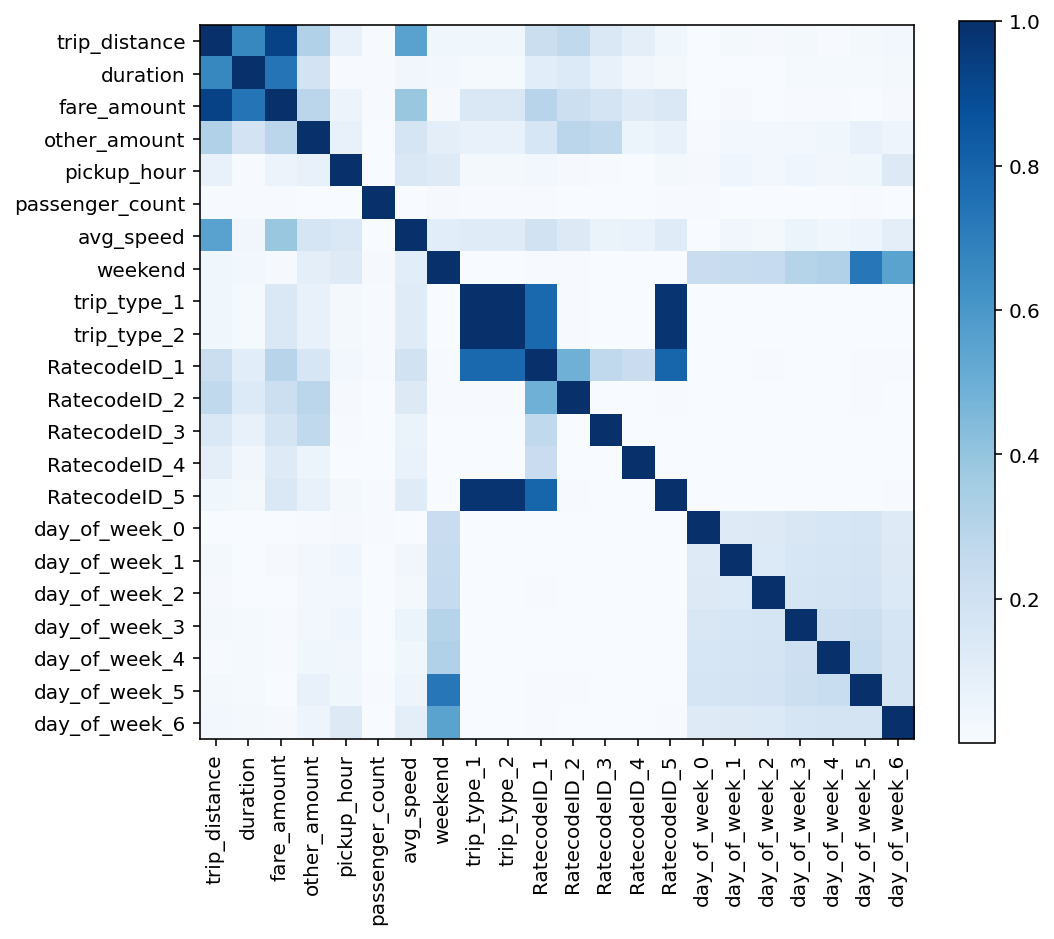

In [78]:
C = X_train.corr()
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

C = np.abs(C)

# Use imshow to display data as an image,with choice of color schemes
im = ax.imshow(C, cmap='Blues')

ax.set_xticks(range(22))
ax.set_xticklabels(list(C.columns), rotation = 90) #set the location and labels of x axis 
ax.set_yticks(range(22))
ax.set_yticklabels(list(C.columns)) #set the location and labels of y axis 

fig.colorbar(im, ax=ax, shrink=.83) #add color bar to indicate value-color map
plt.show()

<div class="alert alert-block alert-success">
    
<h4> As we are interested in the variable importances, we need to remove the highly correlated variables as it may interfere with the feature importances result.
    </h4>
    
- Fare amount and trip distance are highly correlated. Dropping the trip distance.
    
- Trip_type are highly correlated with ratecodeID_5. So dropping trip_type_1, trip_type_2
    
- We are using a combined weekend flag so dropping individual flags - day_of_week_5, day_of_week_6

In [69]:
X_train = X_train.drop(columns=['trip_type_1','trip_type_2','trip_distance','day_of_week_5','day_of_week_6'])
X_test = X_test.drop(columns=['trip_type_1','trip_type_2','trip_distance','day_of_week_5','day_of_week_6'])

### 1.5.1 Random Forest Model -  Hyperparamter tuning

In [70]:
def get_random_values_hyperparameters():
    min_samples_leaf = np.random.randint(low=50, high=100, size=1)[0]
    max_features = np.random.uniform(0.1,0.6)
    max_depth = np.random.randint(low=6, high=20, size=1)[0]
    return min_samples_leaf, max_features, max_depth

In [71]:
## Random Forest Regression Model
# rf = RandomForestRegressor(n_estimators=20, min_samples_leaf=,max_features=, max_depth=8)  
# rf.fit(X_train, y_train) 

for i in range(15):
    h1, h2, h3 = get_random_values_hyperparameters()
    rf = RandomForestRegressor(n_jobs = -1, n_estimators=20, min_samples_leaf=h1,
                                 max_features=h2, max_depth=h3, verbose=1)
    rf.fit(X_train, y_train)
    y_hat_train = rf.predict(X_train)
    y_hat_val = rf.predict(X_test)
    print("min_samples_leaf %d, max_features %.1f, max_depth %d" % (h1, h2, h3))
    print("   train loss %.2f, val loss %.2f" % (mse(y_train, y_hat_train),
          mse(y_test, y_hat_val)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 90, max_features 0.2, max_depth 11
   train loss 53.60, val loss 53.10


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 83, max_features 0.2, max_depth 9
   train loss 53.65, val loss 53.12


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 61, max_features 0.6, max_depth 8
   train loss 53.47, val loss 52.98


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 62, max_features 0.5, max_depth 10
   train loss 53.31, val loss 52.94


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 61, max_features 0.3, max_depth 19
   train loss 52.61, val loss 53.01


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 99, max_features 0.4, max_depth 11
   train loss 53.33, val loss 52.97


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 95, max_features 0.1, max_depth 7
   train loss 53.78, val loss 53.20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 90, max_features 0.1, max_depth 12
   train loss 53.71, val loss 53.20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 95, max_features 0.1, max_depth 15
   train loss 53.46, val loss 53.09


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 91, max_features 0.2, max_depth 16
   train loss 53.18, val loss 53.02


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 66, max_features 0.4, max_depth 14
   train loss 52.89, val loss 52.95


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 66, max_features 0.4, max_depth 14
   train loss 52.85, val loss 52.96


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 76, max_features 0.1, max_depth 14
   train loss 53.47, val loss 53.10


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 84, max_features 0.1, max_depth 17
   train loss 53.43, val loss 53.12


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 53, max_features 0.2, max_depth 19
   train loss 52.52, val loss 53.00


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


<div class="alert alert-block alert-success">
    
<h3> Final Model </h3>

Best Validation loss -> min_samples_leaf 62, max_features 0.5, max_depth 10
 
Values -> train loss 53.31, val loss 52.94

In [72]:
rf = RandomForestRegressor(n_estimators=20, min_samples_leaf=62,max_features=0.5, max_depth=10)  
rf.fit(X_train, y_train) 

RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_leaf=62,
                      n_estimators=20)

### 1.5.2 Feature Importances

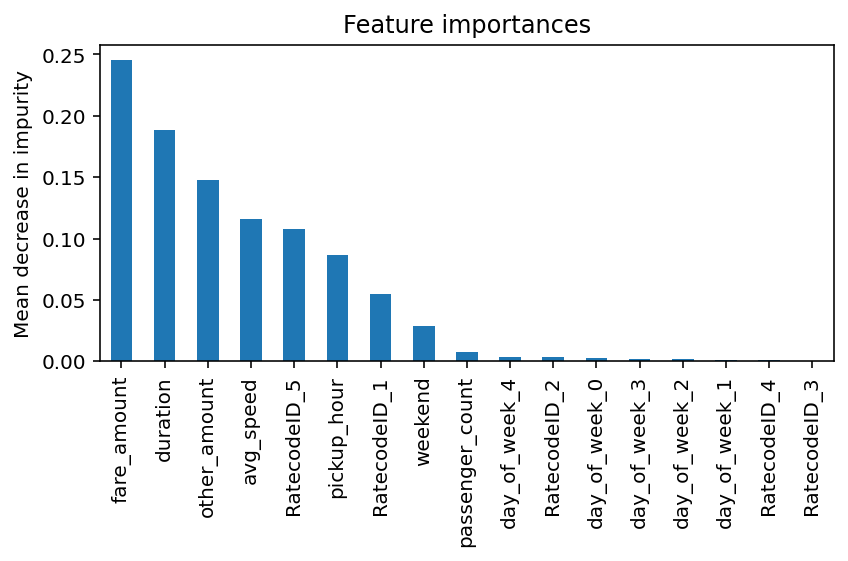

In [73]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
forest_importances.plot.bar()
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Fare Amount

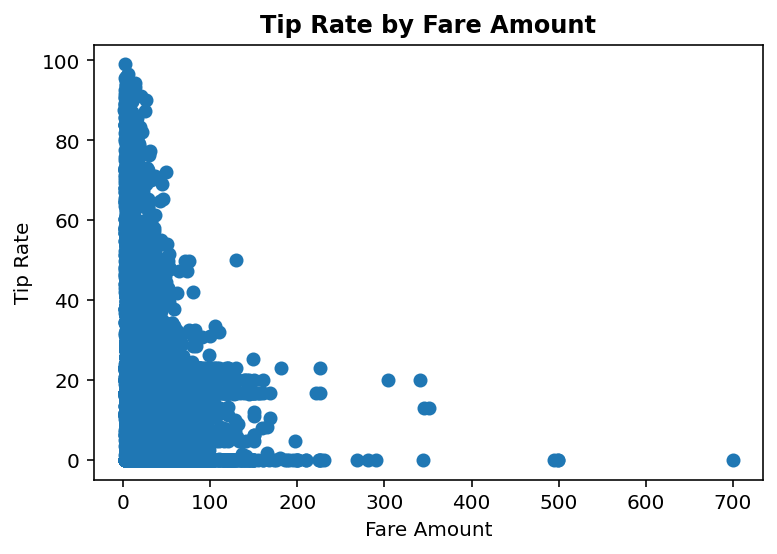

In [33]:
fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(df_tip['fare_amount'], df_tip['tip_rate'] )
ax.set_xlabel("Fare Amount")
ax.set_ylabel("Tip Rate")
ax.set_title("Tip Rate by Fare Amount", weight='bold')
plt.show()

#### Trip duration

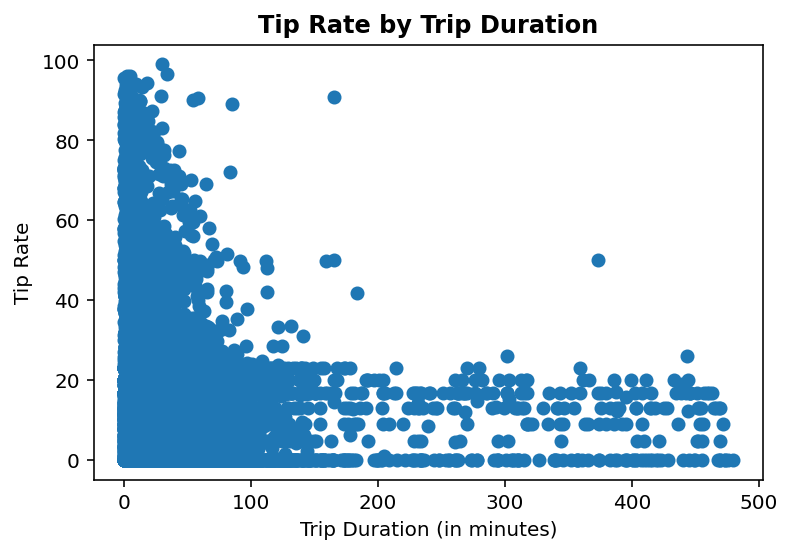

In [168]:
fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(df_tip['duration'],  df_tip['tip_rate'] )
ax.set_xlabel("Trip Duration (in minutes)")
ax.set_ylabel("Tip Rate")
ax.set_title("Tip Rate by Trip Duration", weight='bold')
plt.show()

#### Other Amount

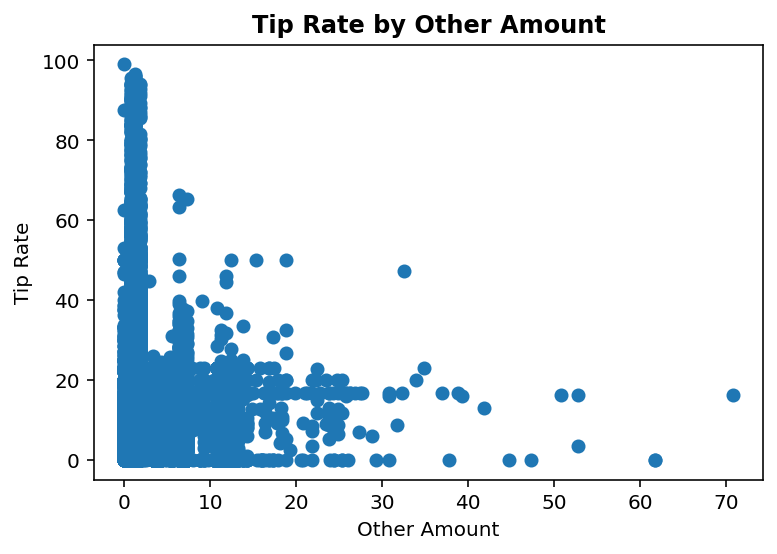

In [169]:
fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(df_tip['other_amount'], df_tip['tip_rate'] )
ax.set_xlabel("Other Amount")
ax.set_ylabel("Tip Rate")
ax.set_title("Tip Rate by Other Amount", weight='bold')
plt.show()

#### Negotiated Fare Flag

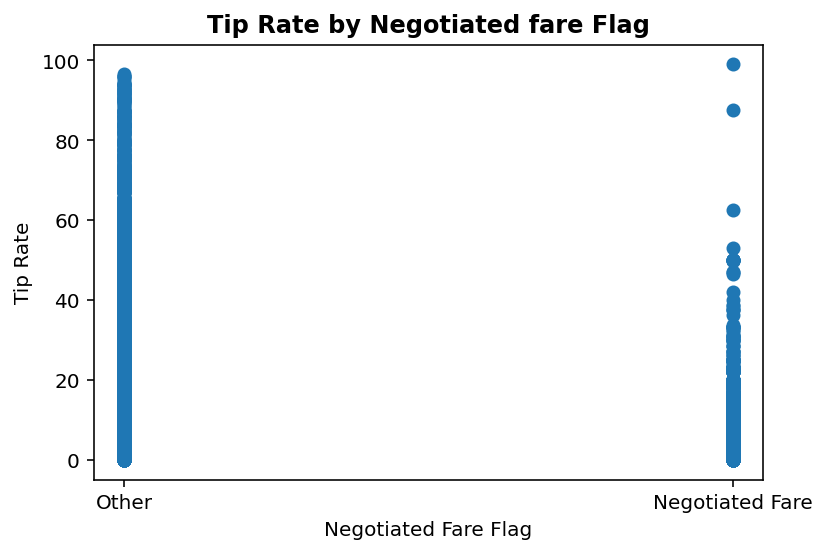

In [170]:
fig, ax = plt.subplots(figsize=(6,4))

df_tip['RatecodeID_5'] = (df_tip['RatecodeID'] == 5).astype(int)

ax.scatter(df_tip['RatecodeID_5'], df_tip['tip_rate'] )
ax.set_xlabel("Negotiated Fare Flag")
ax.set_ylabel("Tip Rate")
ax.set_title("Tip Rate by Negotiated fare Flag", weight='bold')
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Other','Negotiated Fare']) 
plt.show()

#### Avg Speed

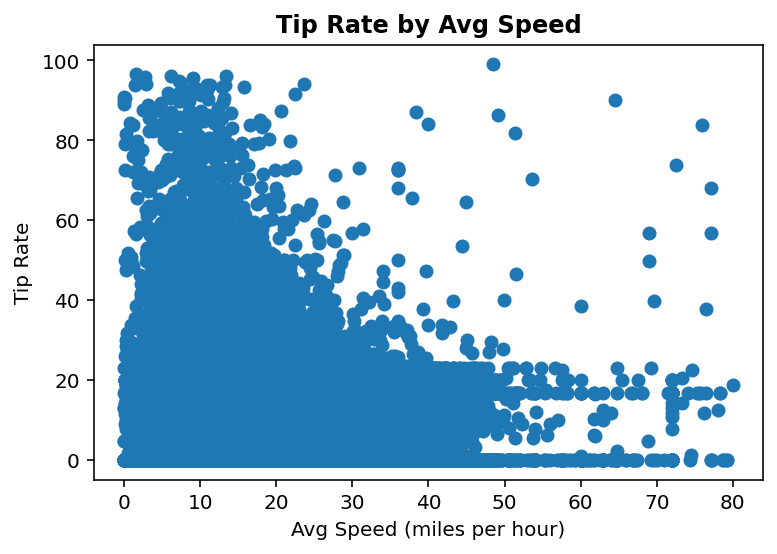

In [171]:
fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(df_tip['avg_speed'], df_tip['tip_rate'] )
ax.set_xlabel("Avg Speed (miles per hour)")
ax.set_ylabel("Tip Rate")
ax.set_title("Tip Rate by Avg Speed", weight='bold')
plt.show()

#### Hour of the day

Text(0.5, 1.0, 'Mean Tip Rate Grouped by Hour of Day')

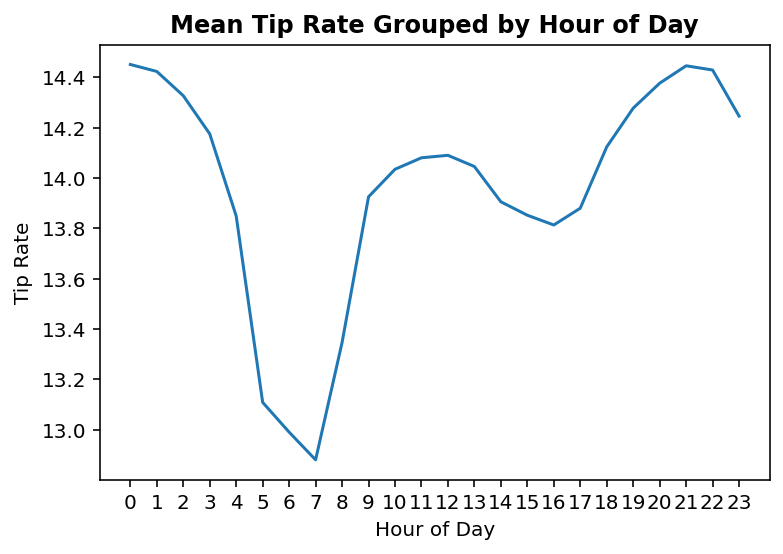

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
## group by hour, get the mean 
mean_dist_pickup = df_tip['tip_rate'].groupby(df_tip['pickup_hour']).mean()

## visualize the dataframe
ax.plot(mean_dist_pickup)
ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Tip Rate")
ax.set_title("Mean Tip Rate Grouped by Hour of Day", weight='bold')

#### Standard Rate Flag

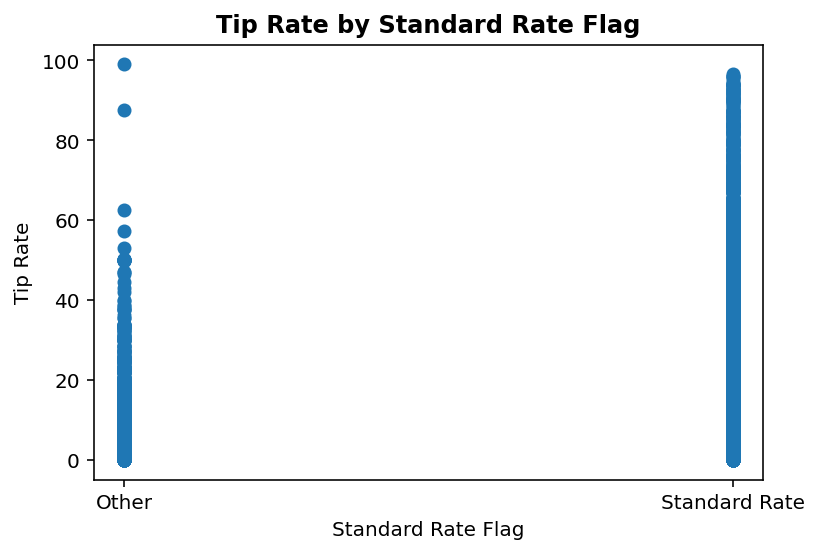

In [173]:
fig, ax = plt.subplots(figsize=(6,4))

df_tip['RatecodeID_1'] = (df_tip['RatecodeID'] == 1).astype(int)

ax.scatter(df_tip['RatecodeID_1'], df_tip['tip_rate'] )
ax.set_xlabel("Standard Rate Flag")
ax.set_ylabel("Tip Rate")
ax.set_title("Tip Rate by Standard Rate Flag", weight='bold')
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Other','Standard Rate']) 
plt.show()

<div class="alert alert-block alert-success">
    
<h4>Most important factors affecting the tip amount:</h4>

<b> 1) Fare Amount</b> - Lower fare amount have higher tip rates.
    
<b> 2) Trip Duration</b> -  Smaller trip duration have higher tip rates.

<b> 3) Other Amount</b> - When the other amount is close to 0, tip rates are observed to be the highest.

<b> 4) Negotiated Fare</b> -  When the ratecode_ID is of the negotiated fare type, the tip rates are smaller from the trips with other ratecodeIDs.
    
<b> 5) Avg Speed</b> - Average speed in the range of 10-20 miles per hour is supposed to align with maximum tip rates.
    
<b> 6) Hour of the day</b> - Tip rates are the lowest during early morning hours, average during the day and the maximum from 8 PM to 2 AM
    
<b> 7) Standard Rate</b> - When the ratecode_ID is of the standard rate type, the tip rates are higher from the trips with other ratecodeIDs
    
    
From the above factors, we can conclude that customers are willing to pay higher tip rates at lower fare amount trips. This means customers think more from absolute tips than tip percentage of total amount - thus they are willing to shed more tip rates for smaller tips but when the total amount is high they withdraw from paying higher tip rates (in terms of amount they may be relatively higher than smaller trips but not proportionate).


## 1.6 Anomaly Detection

Reading the data again as we don't want to drop anything before looking for anomalies. Our outliers could be anomalies so we will not drop anything here.

In [50]:
df = pd.read_parquet('green_tripdata_2016-12.parquet', engine='pyarrow')

df['day_of_week'] = pd.Categorical(pd.to_datetime(df['lpep_pickup_datetime']).dt.dayofweek)
df['pickup_hour'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.hour
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
#duration in minutes
df['duration'] = pd.to_timedelta(df['duration'])/pd.Timedelta('60s')
df = df.drop(columns=['ehail_fee','congestion_surcharge','lpep_pickup_datetime','lpep_dropoff_datetime',\
                      'VendorID',"PULocationID","DOLocationID","store_and_fwd_flag"])

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224158 entries, 0 to 1224157
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   RatecodeID             1224158 non-null  int64   
 1   passenger_count        1224158 non-null  int64   
 2   trip_distance          1224158 non-null  float64 
 3   fare_amount            1224158 non-null  float64 
 4   extra                  1224158 non-null  float64 
 5   mta_tax                1224158 non-null  float64 
 6   tip_amount             1224158 non-null  float64 
 7   tolls_amount           1224158 non-null  float64 
 8   improvement_surcharge  1224158 non-null  float64 
 9   total_amount           1224158 non-null  float64 
 10  payment_type           1224158 non-null  int64   
 11  trip_type              1224158 non-null  int64   
 12  day_of_week            1224158 non-null  category
 13  pickup_hour            1224158 non-null  int64   
 14  du

In [52]:
# scaling the inputs as it's easier and quicker for the algorithm to find anomalies

scalar = StandardScaler()

X = df

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

X_train_tr = scalar.fit_transform(X_train)
X_test_tr = scalar.transform(X_test)

In [116]:
print(f"TRAINING: X_train: {X_train.shape}")
print(f"TESTING: X_test: {X_test.shape}")

TRAINING: X_train: (856910, 15)
TESTING: X_test: (367248, 15)


In [109]:
clf = IsolationForest(n_estimators=100, random_state=42, contamination=0.007)
clf.fit(X_train)
y_train_pred = clf.predict(X_train_tr)
y_test_pred = clf.predict(X_test_tr)
scores = clf.decision_function(X_test_tr)

In [110]:
anomaly = X_train[y_train_pred==-1]
non_anomaly = X_train[y_train_pred==1]

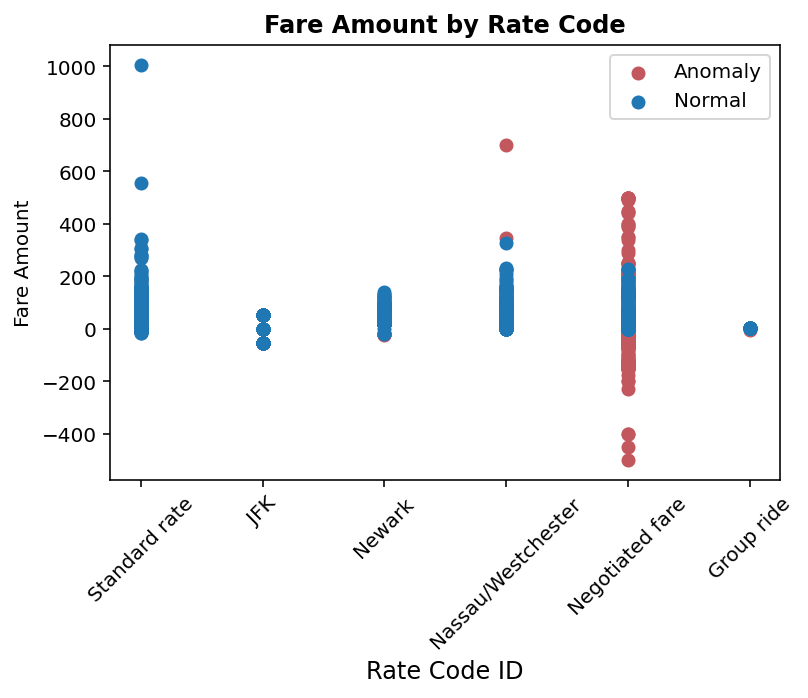

In [111]:
fig, ax = plt.subplots()

pt_type_fare=["Standard rate", "JFK","Newark","Nassau/Westchester", "Negotiated fare", "Group ride"]
ax.scatter(anomaly['RatecodeID'], anomaly['fare_amount'], color='#c2575e', label='Anomaly')
ax.scatter(non_anomaly['RatecodeID'], non_anomaly['fare_amount'], label ='Normal')

ax.set_xlabel("Rate Code ID", size=12)
ax.set_ylabel("Fare Amount")
ax.set_title("Fare Amount by Rate Code", weight="bold")
ax.set_xticks(range(1,7))
ax.set_xticklabels(pt_type_fare) 
ax.legend()
plt.xticks(rotation = 45)
plt.show()

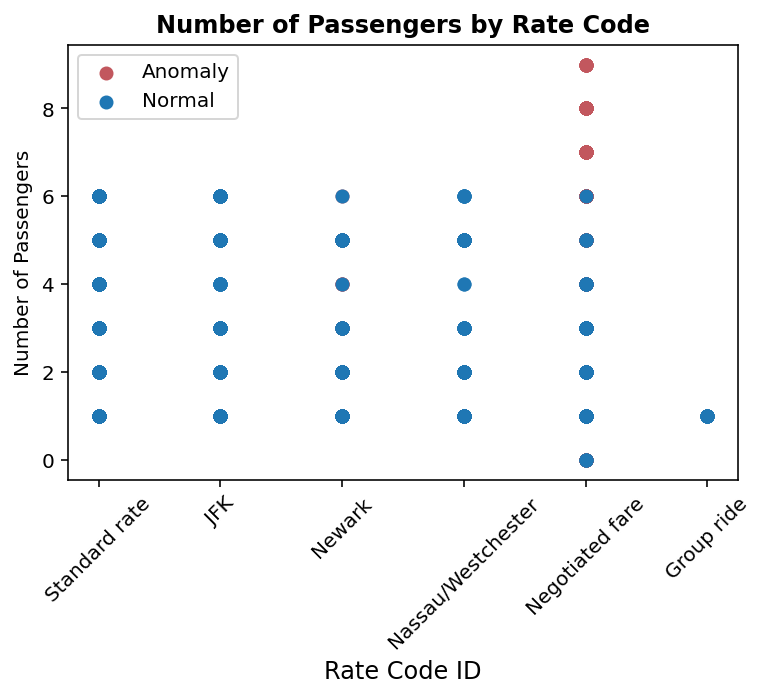

In [115]:
fig, ax = plt.subplots()

pt_type_fare=["Standard rate", "JFK","Newark","Nassau/Westchester", "Negotiated fare", "Group ride"]
ax.scatter(anomaly['RatecodeID'], anomaly['passenger_count'], color='#c2575e', label='Anomaly')
ax.scatter(non_anomaly['RatecodeID'], non_anomaly['passenger_count'], label ='Normal')

ax.set_xlabel("Rate Code ID", size=12)
ax.set_ylabel("Number of Passengers")
ax.set_title("Number of Passengers by Rate Code", weight="bold")
ax.set_xticks(range(1,7))
ax.set_xticklabels(pt_type_fare) 
ax.legend()
plt.xticks(rotation = 45)
plt.show()

<div class="alert alert-block alert-success">
<h4>Negotiated Fare rides with high absolute fare amount are mostly anamolies.</h4>

- As this fare is negatioated between the driver and the passenger, it's different from all the other fare amounts. 

- The distance reported for such trips is also not accurate as it has been reported by driver and not calculated by meter.

- The negotiated rides also have unusually high number of passengers which is greater than 6. They are higher than the capacity of most cars.
